<a href="https://colab.research.google.com/github/federicoweill/pycardano-tutorial/blob/main/pycardano_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Python Jupyter Notebook for Cardano on Demeter

In [1]:
cd ~/workspace/repo/time_series/

/config/workspace/repo/time_series


In [6]:
!pip install -r requirement.txt

Defaulting to user installation because normal site-packages is not writeable


In [4]:
!pip install matplotlib cbor2 pycardano

Defaulting to user installation because normal site-packages is not writeable


In [5]:
"""Single-script demo to show how to access on on-chain datum."""
# pylint: disable=W0718, C0206

import json
import logging
import sys
from collections import OrderedDict
from dataclasses import dataclass
from datetime import datetime, timezone
from typing import Final

import cbor2
import numpy
import pycardano
from pycardano import Address, Network, OgmiosChainContext, UTxO

OGMIOS_URL: Final[str] = "ws://ogmios.preprod.orcfax.io:1337"

# smart contract
ADA_USD_ORACLE_ADDR: Final[
    str
] = "addr_test1wrtcecfy7np3sduzn99ffuv8qx2sa8v977l0xql8ca7lgkgmktuc0"

auth_addr = Address.from_primitive(
    "addr_test1vrc7lrdcsz08vxuj4278aeyn4g82salal76l54gr6rw4ync86tfse"
)

# policy ID for the Auth tokens
AUTH_POLICY: Final[str] = "104d51dd927761bf5d50d32e1ede4b2cff477d475fe32f4f780a4b21"

network = Network.TESTNET
context = OgmiosChainContext(ws_url=OGMIOS_URL, network=network)

logger = logging.getLogger(__name__)

logging.basicConfig(
    format="%(asctime)-15s %(levelname)s :: %(filename)s:%(lineno)s:%(funcName)s() :: %(message)s",
    datefmt="%Y-%m-%dT%H:%M:%SZ",
    level="INFO",
)


def _decode_number(value_pair: list):
    """Decode a number value."""
    significand = numpy.uint64(value_pair[0]).astype(numpy.int64)
    base10_component = numpy.uint64(value_pair[1]).astype(numpy.int64)
    value = significand * 10 ** numpy.float_(base10_component)
    return value


def timestamp_to_human(timestamp):
    return datetime.utcfromtimestamp(int(timestamp) / 1000).strftime(
        "%Y-%m-%dT%H:%M:%SZ"
    )


def decode_utxo(utxo: pycardano.transaction.UTxO):
    """Split a UTxO into the components that we need to process and
    initially return the Orcfax Datum."""
    oracle_datum = cbor2.loads(utxo.output.datum.cbor)
    timestamp = oracle_datum.value[2].value[0]
    timestamp_human = timestamp_to_human(timestamp)
    logger.info("oracle datum timestamp: %s (%s)", timestamp_human, timestamp)
    labels = oracle_datum.value[0][b"name"].decode().split("|", 1)
    ada_usd = oracle_datum.value[0][b"value"][0].value
    pretty_log_value(ada_usd, labels[0])
    return (timestamp, _decode_number(ada_usd))


def pretty_log_value(value_pair: cbor2.CBORTag, label: str):
    """Return pretty logging information about a value pair."""
    value = _decode_number(value_pair)
    logger.info("%s: %s", label, value)


def validate_utxo(utxo: UTxO):
    """check if the token included in the utxo is the correct one."""
    valid = False
    for item in utxo.output.amount.multi_asset:
        if str(item) == AUTH_POLICY:
            valid = True
            for asset in utxo.output.amount.multi_asset[item]:
                amount = utxo.output.amount.multi_asset[item][asset]
                logger.info("found %d %s", amount, str(asset))
    return valid


def get_utxos(oracle_addr: str):
    """return the Orcfax UTxOs."""
    oracle_utxos = context.utxos(oracle_addr)
    utxos = []
    logger.info("inspecting '%s' UTxOs", len(oracle_utxos))
    for utxo in oracle_utxos:
        if not utxo.output.script and utxo.output.datum and validate_utxo(utxo):
            utxos.append(utxo)
    return utxos


def read_datum():
    """Get the timestamps and prices from all validated Orcfax UTxOs."""
    logger.info("entering this script... ")
    logger.info("oracle smart contract: %s", ADA_USD_ORACLE_ADDR)
    utxos = get_utxos(ADA_USD_ORACLE_ADDR)
    times_prices = []
    if not utxos:
        logger.info("no oracle data found")
        sys.exit(0)
    for utxo in utxos:
        (timestamp, ada_usd) = decode_utxo(utxo)
        times_prices.append((timestamp, ada_usd))
    return times_prices

In [6]:
times_prices = read_datum()
times_prices.sort(key=lambda tp: tp[0])

2024-01-03T03:02:53Z INFO :: 1906248053.py:101:read_datum() :: entering this script... 
2024-01-03T03:02:53Z INFO :: 1906248053.py:102:read_datum() :: oracle smart contract: addr_test1wrtcecfy7np3sduzn99ffuv8qx2sa8v977l0xql8ca7lgkgmktuc0
2024-01-03T03:02:56Z INFO :: 1906248053.py:92:get_utxos() :: inspecting '872' UTxOs
2024-01-03T03:02:56Z INFO :: 1906248053.py:84:validate_utxo() :: found 1 f874dd4a0978bc3c4b605d778ceaeda3331b28b9aba0c47283ce9efb50391222
2024-01-03T03:02:56Z INFO :: 1906248053.py:84:validate_utxo() :: found 1 c7a60cddf97be8bd153805e2662abb64418398f0fabaeb70ed36d89970ef4721
2024-01-03T03:02:56Z INFO :: 1906248053.py:84:validate_utxo() :: found 1 f7711c1fdfad9913246eb0f2a40a10abb8e81e86d8d0ee83e62616feb0e52ba0
2024-01-03T03:02:56Z INFO :: 1906248053.py:84:validate_utxo() :: found 1 2a27baa19a26d3582713bb36776873b87fddcc5b37b7d35920fc5ed406779ee2
2024-01-03T03:02:56Z INFO :: 1906248053.py:84:validate_utxo() :: found 1 28757269fdcd391470b3b5b513ab78c6d8621463f8af9395fef72

2024-01-03T03:03:19Z INFO :: font_manager.py:1578:_load_fontmanager() :: generated new fontManager


2024-01-02T08:42:15Z,0.6287203876
2024-01-02T09:02:23Z,0.6275706552
2024-01-02T10:02:26Z,0.632921
2024-01-02T11:02:29Z,0.63175
2024-01-02T12:02:01Z,0.6281581628
2024-01-02T13:02:04Z,0.6258092604000001
2024-01-02T14:02:07Z,0.6229845666
2024-01-02T15:02:10Z,0.625896
2024-01-02T15:35:26Z,0.6191
2024-01-02T15:52:32Z,0.6124729999999999
2024-01-02T16:02:12Z,0.6135
2024-01-02T17:02:15Z,0.6141155802
2024-01-02T18:02:18Z,0.6179
2024-01-02T18:44:02Z,0.6115459999999999
2024-01-02T19:02:21Z,0.6139931427
2024-01-02T20:02:23Z,0.61475
2024-01-02T21:02:26Z,0.6146499054
2024-01-02T21:53:33Z,0.6083746506000001
2024-01-02T22:02:29Z,0.606603
2024-01-02T23:02:02Z,0.6039317622
2024-01-03T00:02:04Z,0.608287
2024-01-03T01:02:07Z,0.6050374568
2024-01-03T02:02:10Z,0.6069500000000001
2024-01-03T03:02:13Z,0.6110412574
2024-01-03T04:02:15Z,0.6092000000000001


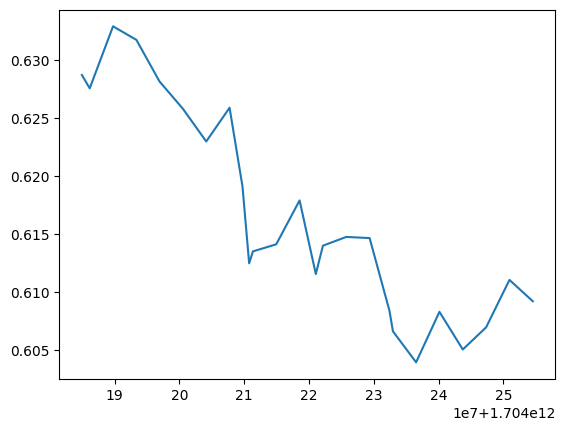

In [7]:
import matplotlib.pyplot as plt
for tp in times_prices:
    print("{0},{1}".format(timestamp_to_human(tp[0]),tp[1]))

plt.plot(*zip(*times_prices))

In [2]:
cd ~/workspace/repo/time_series/

/config/workspace/repo/time_series


In [8]:
!python3 service.py

Traceback (most recent call last):
  File "/config/workspace/repo/time_series/service.py", line 34, in <module>
    invoke_service() # call invoke service method
  File "/config/workspace/repo/time_series/service.py", line 30, in invoke_service
    response = service_client.service.forecast(request) # replace service_method
  File "/config/.local/lib/python3.10/site-packages/grpc/_interceptor.py", line 277, in __call__
    response, ignored_call = self._with_call(
  File "/config/.local/lib/python3.10/site-packages/grpc/_interceptor.py", line 329, in _with_call
    call = self._interceptor.intercept_unary_unary(
  File "/config/.local/lib/python3.10/site-packages/snet/sdk/generic_client_interceptor.py", line 27, in intercept_unary_unary
    new_details, new_request_iterator, postprocess = self._fn(
  File "/config/.local/lib/python3.10/site-packages/snet/sdk/service_client.py", line 85, in _intercept_call
    metadata.extend(self._get_service_call_metadata())
  File "/config/.local/lib

In [8]:
# WARNING: RUN THIS CELL IFF USING PYTHON>=3.10
def findReplace(filename, find, replace):
    with open(filename, 'r') as file:
        filedata = file.read()
    filedata = filedata.replace(find, replace)
    with open(filename, 'w') as file:
        file.write(filedata)

findReplace("/config/.local/lib/python3.10/site-packages/attrdict/default.py", "from collections import", "from collections.abc import")
findReplace("/config/.local/lib/python3.10/site-packages/attrdict/mapping.py", "from collections import", "from collections.abc import")
findReplace("/config/.local/lib/python3.10/site-packages/attrdict/merge.py", "from collections import", "from collections.abc import")
findReplace("/config/.local/lib/python3.10/site-packages/attrdict/mixins.py", "from collections import", "from collections.abc import")
findReplace("/config/.local/lib/python3.10/site-packages/eth_account/account.py", "from collections import", "from collections.abc import")
findReplace("/config/.local/lib/python3.10/site-packages/rlp/codec.py", "import collections\n", "import collections.abc as collections\n")
findReplace("/config/.local/lib/python3.10/site-packages/rlp/lazy.py", "from collections import", "from collections.abc import")
findReplace("/config/.local/lib/python3.10/site-packages/rlp/sedes/lists.py", "from collections import", "from collections.abc import")
findReplace("/config/.local/lib/python3.10/site-packages/rlp/sedes/raw.py", "from collections import", "from collections.abc import")
findReplace("/config/.local/lib/python3.10/site-packages/rlp/sedes/serializable.py", "import collections\n", "import collections\nimport collections.abc\n")
findReplace("/config/.local/lib/python3.10/site-packages/rlp/sedes/serializable.py", "collections.Sequence", "collections.abc.Sequence")
findReplace("/config/.local/lib/python3.10/site-packages/web3/datastructures.py", "from collections import (\n    Hashable,\n    Mapping,\n    MutableMapping,\n    OrderedDict,\n    Sequence,\n)", "from collections.abc import (\n    Hashable,\n    Mapping,\n    MutableMapping,\n    Sequence,\n)\nfrom collections import OrderedDict")
findReplace("/config/.local/lib/python3.10/site-packages/web3/utils/six/six.py", "import collections\n", "import collections.abc as collections\n")
findReplace("/config/.local/lib/python3.10/site-packages/web3/utils/formatters.py", "from collections import", "from collections.abc import")